## JHU channel flow

### Created by Yuying Liu, 12/03/2019

In [1]:
# imports
import os
import cv2
import sys
import torch
import pickle
# import pyJHTDB
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

Text(0.5,1,'sampled snapshot')

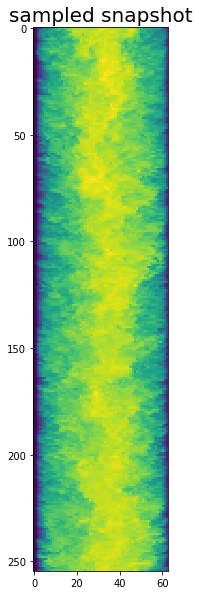

In [2]:
if os.path.exists('../data/npy/channel_flow2.npy'):
    data = np.load('../data/npy/channel_flow2.npy')
else:
    # load shared library
    lTDB = pyJHTDB.libJHTDB()
    #initialize webservices
    lTDB.initialize()

    # add token
    auth_token  = "edu.uw.yliu814-dff25860"  # get ur own token from: http://turbulence.pha.jhu.edu/authtoken.aspx
    lTDB.add_token(auth_token)
    
    # info
    n = 3
    info = pyJHTDB.dbinfo.channel
    name = info['name']
    x_sample_factor = 4
    y_sample_factor = 4
    nx = info['nx'] // x_sample_factor
    ny = info['ny'] // y_sample_factor
    xnodes = info['xnodes'][::x_sample_factor]
    ynodes = info['ynodes'][::y_sample_factor]
    zmid = 1.5*np.pi
    
    lpoints = []
    for i in range(nx):
        for j in range(ny):
            lpoints.append([xnodes[i], ynodes[j], zmid])
            
    points = np.array(lpoints, dtype='float32')
    
    data = []
    for t in info['time'][::8]:
        sample = lTDB.getData(t, points, data_set = name, getFunction = 'getVelocity')
        sample = np.reshape(sample, (nx, ny, n))
        print('time t: ', t, ', sample shape: ', sample.shape)
        data.append(sample)
    
    data = np.stack(data, 0)
    Phi = np.squeeze(data[:, :-1, :-1, 0])
    data = (Phi - Phi.min()) / (Phi.max() - Phi.min())
    np.save('../data/npy/channel_flow.npy', data)
    
# viz
plt.figure(figsize=(5, 10))
plt.imshow(data[1, :, :])
plt.title('sampled snapshot',fontsize=20)

In [3]:
# init model & load data
data_path = '../data/npy/channel_flow2.npy'
model_path = '../model/fluid2/'
result_path = '../result/fluid2/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=4)

In [4]:
# training
archs = [[1,2,3,4,5],[1,3,5,7,9],[1,4,7,10,13],[1,6,11,16,21]]
tols = [0.02, 0.01, 0.008, 0.005]
net.train_net(archs=archs, dataset=dataset, max_epoch=4000, batch_size=350, tols=tols, activation=torch.nn.Sequential(), 
              w=0.5, model_path=model_path, result_path=result_path, std=0.01, verbose=2)

# of filters in each group:  [1, 1, 1, 1]
*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/5000]
[training set] local: 0.0184/0.0555/0.0369, global: 0.0571/0.5384/0.2977
[validation set] local: 0.0187/0.0605/0.0396, global: 0.0573/0.5440/0.3007
epoch [500/5000]:
[training set] local: 0.0066/0.0139/0.0102, global: 0.0300/0.3595/0.1948
[validation set] local: 0.0066/0.0147/0.0107, global: 0.0302/0.3636/0.1969
early stopping at 500th iteration due to satisfying reconstruction!

-------------------------------------------------
*************************************************
# of filters in each group:  [2, 2, 2, 2]
*************************************************
Model @Level 1:
Perform deepening & widening, train each architectures ...
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/5000]
[training

/usr/lib/python3/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2dBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3/dist-packages/torch/serialization.py:292: U

epoch [500/5000]:
[training set] local: 0.0172/0.0317/0.0245, global: 0.0220/0.1881/0.1050
[validation set] local: 0.0173/0.0365/0.0269, global: 0.0220/0.1899/0.1059
epoch [1000/5000]:
[training set] local: 0.0159/0.0305/0.0232, global: 0.0216/0.1880/0.1048
[validation set] local: 0.0160/0.0352/0.0256, global: 0.0217/0.1917/0.1067
epoch [1500/5000]:
[training set] local: 0.0152/0.0294/0.0223, global: 0.0217/0.2057/0.1137
[validation set] local: 0.0152/0.0329/0.0241, global: 0.0218/0.2092/0.1155
epoch [2000/5000]:
[training set] local: 0.0144/0.0291/0.0217, global: 0.0219/0.2268/0.1243
[validation set] local: 0.0145/0.0333/0.0239, global: 0.0220/0.2302/0.1261
epoch [2500/5000]:
[training set] local: 0.0143/0.0275/0.0209, global: 0.0216/0.2217/0.1216
[validation set] local: 0.0144/0.0321/0.0232, global: 0.0216/0.2261/0.1239
epoch [3000/5000]:
[training set] local: 0.0138/0.0270/0.0204, global: 0.0212/0.2248/0.1230
[validation set] local: 0.0139/0.0316/0.0228, global: 0.0213/0.2263/0.1238

epoch [500/5000]:
[training set] local: 0.0048/0.0182/0.0115, global: 0.0053/0.0674/0.0364
[validation set] local: 0.0049/0.0206/0.0127, global: 0.0053/0.0684/0.0369
epoch [1000/5000]:
[training set] local: 0.0037/0.0135/0.0086, global: 0.0041/0.0560/0.0301
[validation set] local: 0.0037/0.0151/0.0094, global: 0.0041/0.0597/0.0319
epoch [1500/5000]:
[training set] local: 0.0035/0.0115/0.0075, global: 0.0038/0.0544/0.0291
[validation set] local: 0.0035/0.0125/0.0080, global: 0.0038/0.0557/0.0298
epoch [2000/5000]:
[training set] local: 0.0032/0.0094/0.0063, global: 0.0034/0.0482/0.0258
[validation set] local: 0.0033/0.0117/0.0075, global: 0.0034/0.0497/0.0266
epoch [2500/5000]:
[training set] local: 0.0030/0.0096/0.0063, global: 0.0032/0.0490/0.0261
[validation set] local: 0.0030/0.0106/0.0068, global: 0.0032/0.0495/0.0263
epoch [3000/5000]:
[training set] local: 0.0029/0.0093/0.0061, global: 0.0032/0.0490/0.0261
[validation set] local: 0.0029/0.0099/0.0064, global: 0.0031/0.0494/0.0263

epoch [4500/5000]:
[training set] local: 0.0025/0.0130/0.0078, global: 0.0025/0.0130/0.0078
[validation set] local: 0.0025/0.0143/0.0084, global: 0.0025/0.0143/0.0084
epoch [5000/5000]:
[training set] local: 0.0025/0.0127/0.0076, global: 0.0025/0.0127/0.0076
[validation set] local: 0.0025/0.0152/0.0089, global: 0.0025/0.0152/0.0089

-------------------------------------------------
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/5000]
[training set] local: 0.0025/0.0140/0.0082, global: 0.0025/0.0140/0.0082
[validation set] local: 0.0025/0.0165/0.0095, global: 0.0025/0.0165/0.0095
epoch [500/5000]:
[training set] local: 0.0023/0.0098/0.0061, global: 0.0023/0.0098/0.0061
[validation set] local: 0.0023/0.0106/0.0064, global: 0.0023/0.0106/0.0064
epoch [1000/5000]:
[training set] local: 0.0021/0.0088/0.0054, global: 0.0021/0.0088/0.0054
[validation set] local: 0.0021/0.0093/0.0057, global: 0.0021/0.0093/0.0057
epoch [1500/5000]:
[training set] local: 0.0020

### Results

In [5]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L1_0
model_L1_1
model_L1_2
model_L1_3
model_L2_0
model_L2_1
model_L2_2
model_L2_3
model_L2_4
model_L3_0
model_L3_1
model_L3_2
model_L3_3
model_L3_4


dict_keys(['0'])
dict_keys(['0', '1', '2', '3'])
dict_keys(['0', '1', '2', '3', '4'])
dict_keys(['0', '1', '2', '3', '4'])


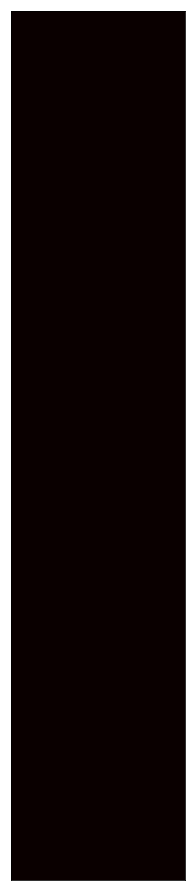

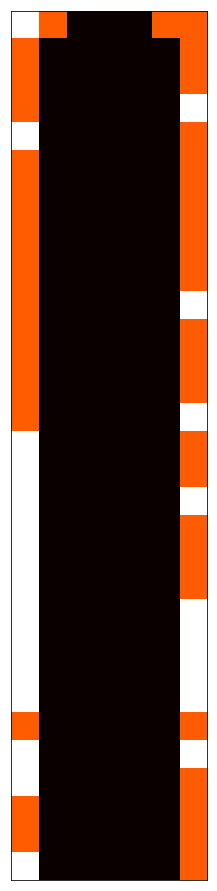

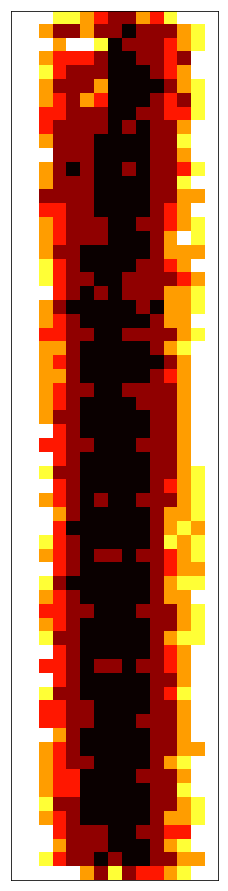

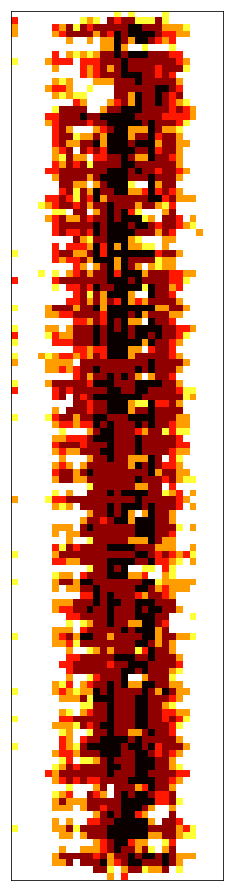

In [6]:
# choose the finest model
model = models['model_L3_4']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(4):
    print(model.resolved_maps[str(i)].keys())
    
for i in range(4):
    level_maps = model.resolved_maps[str(i)]
    for key in level_maps.keys():
        if key == '0':
            intensities = (1 - level_maps[key])
        else:
            intensities += (1 - level_maps[key])
    file_name = 'L{}.png'.format(i)
    fig, ax = plt.subplots(1, 1, figsize=(4, 16))
    ax.imshow(intensities.cpu().detach().numpy(), cmap='hot')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.savefig(os.path.join(result_path, file_name))

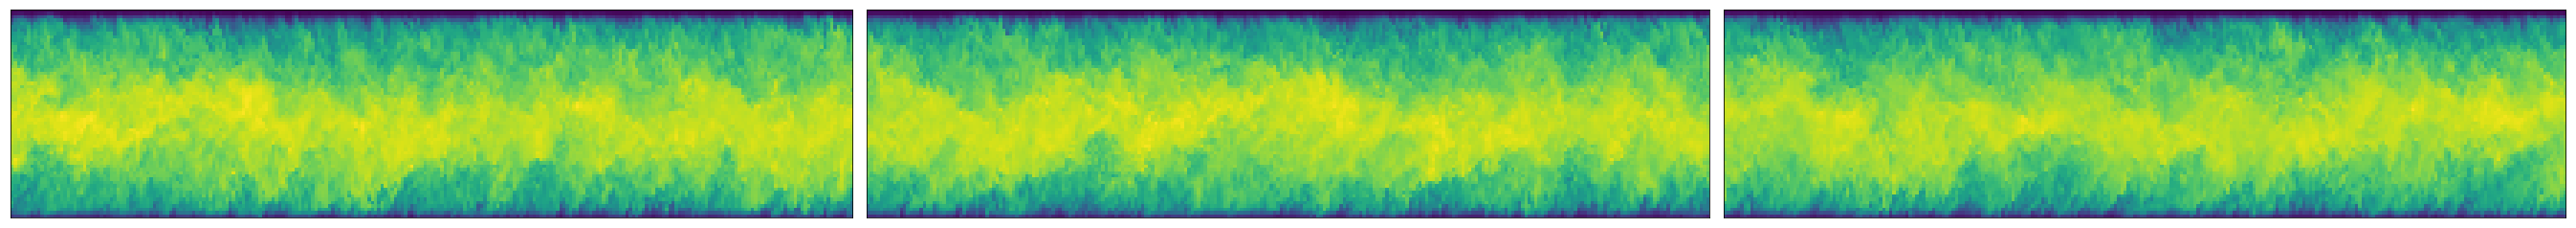

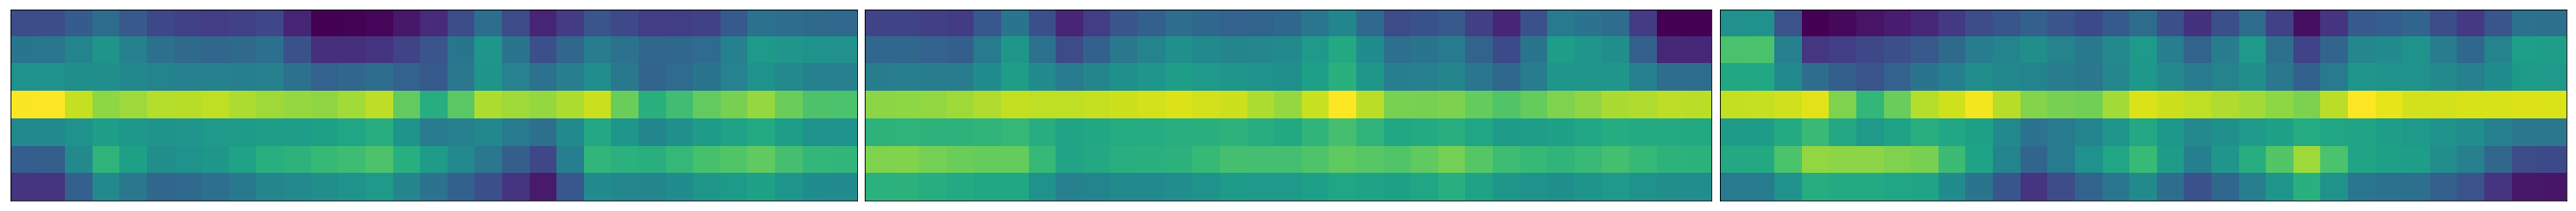

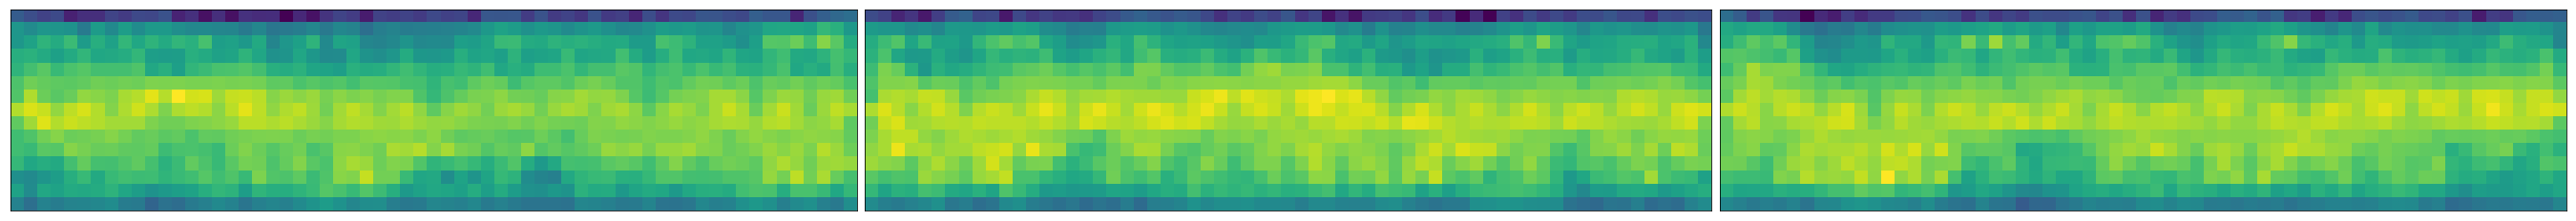

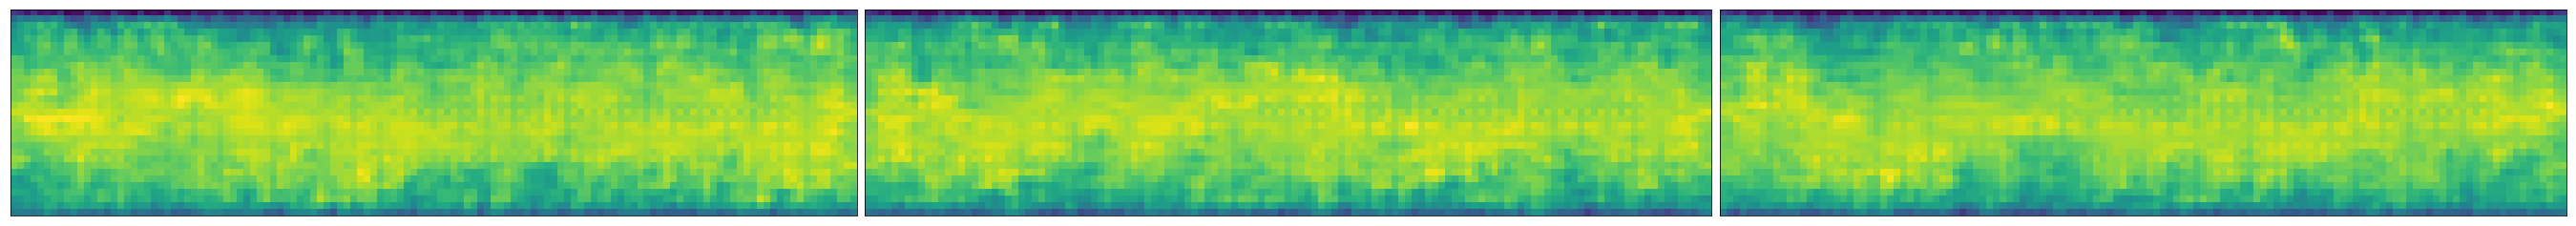

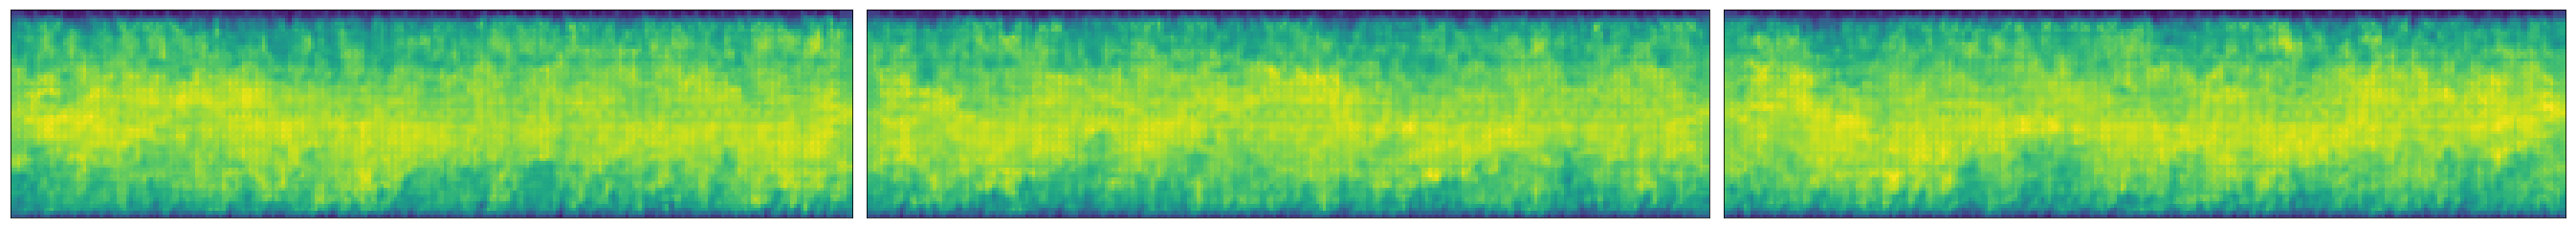

In [7]:
inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 3
n_step = n_snapshots // 3

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].imshow(dataset.data[inds[i*n_step], :, :, :].squeeze().T.cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_0']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_4']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

model = models['model_L3_4']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*16, 4))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=3)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].imshow(output.squeeze().cpu().T.detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L3_reconstructions.png'), bbox_inches='tight')

In [8]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

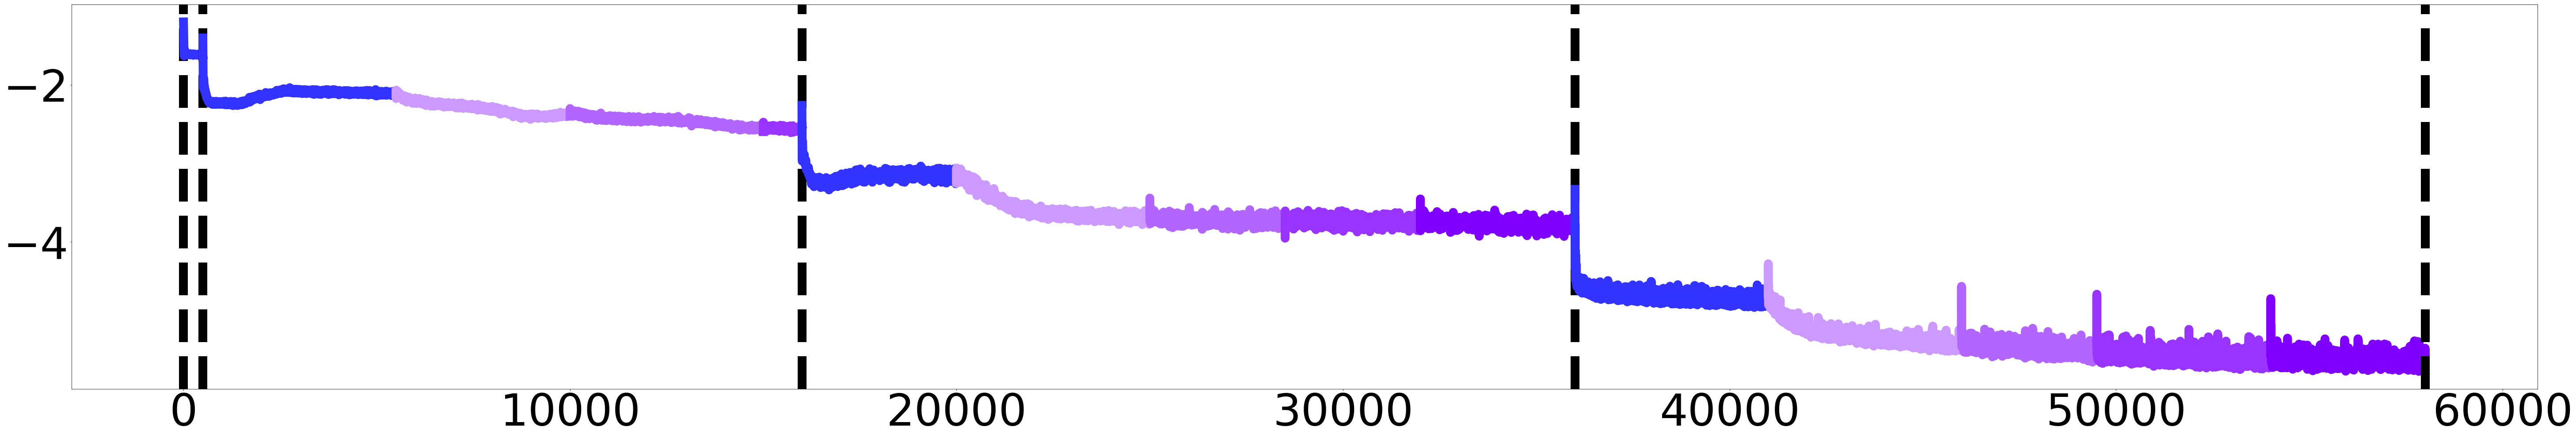

In [9]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(100, 16))

# plot
s = 0
for i in range(4):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))